In [35]:
#Data Preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')

# Drop Loan_ID column
df.drop(columns=['Loan_ID'], inplace=True)

#Handle missing values
df.fillna(method='ffill', inplace=True)

#Split data
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status'].apply(lambda x:1 if x == 'Y' else 0)

#Preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X = preprocessor.fit_transform(X)

# Ensure X is a DataFrame with column names for SHAP
feature_names = list(preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_features)) + \
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

X = pd.DataFrame(X, columns=feature_names)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

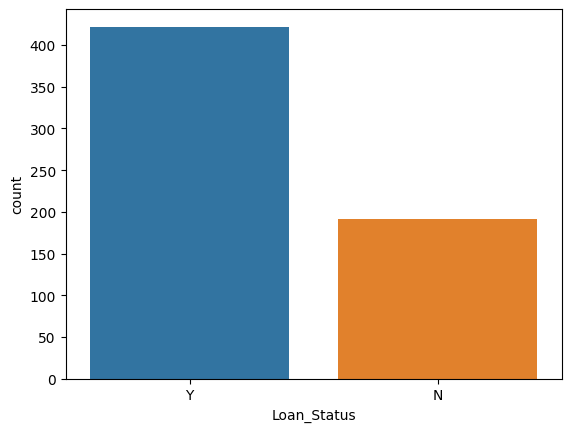

In [36]:
#Exploratory Data Analysis (EDA)

import seaborn as sns
import matplotlib.pyplot as plt

# Example: visualise the distribution of the target variable
sns.countplot(x='Loan_Status', data=df)
plt.show()

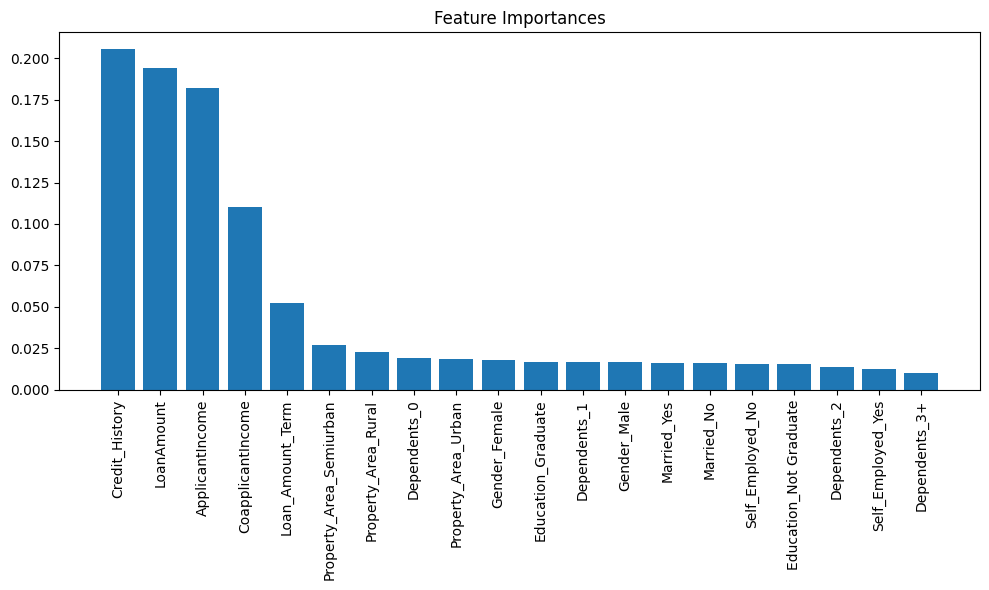

In [37]:
# Feature Selection

import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train a RandomForest model for feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# Select top N features (for example, top 10 features)
top_n_features = X_train.columns[indices][:10]
X_train = X_train[top_n_features]
X_test = X_test[top_n_features]

In [42]:
# Model Training

import optuna
from sklearn.model_selection import cross_val_score

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Define the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters
print(study.best_params)

# Train the best model
best_model = RandomForestClassifier(**study.best_params)
best_model.fit(X_train, y_train)

[I 2024-06-13 02:58:26,363] A new study created in memory with name: no-name-7006b65f-42c7-4f26-8333-8e2728036119
[I 2024-06-13 02:58:27,272] Trial 0 finished with value: 0.7726843930975689 and parameters: {'n_estimators': 236, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.7726843930975689.
[I 2024-06-13 02:58:28,828] Trial 1 finished with value: 0.7761740208327209 and parameters: {'n_estimators': 395, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7761740208327209.
[I 2024-06-13 02:58:31,665] Trial 2 finished with value: 0.7717651958334558 and parameters: {'n_estimators': 746, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.7761740208327209.
[I 2024-06-13 02:58:34,402] Trial 3 finished with value: 0.7748818237939854 and parameters: {'n_estimators': 692, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 1 with valu

{'n_estimators': 455, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 2}


RandomForestClassifier(max_depth=19, min_samples_leaf=2, min_samples_split=20,
                       n_estimators=455)

In [43]:
# Model Testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.80
Precision: 0.78
Recall: 0.97
F1 Score: 0.87
ROC AUC Score: 0.73
[[21 22]
 [ 2 78]]


In [44]:
# Model Development

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Example: Random Forest
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [45]:
# Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.81      0.49      0.61        43
           1       0.77      0.94      0.85        80

    accuracy                           0.78       123
   macro avg       0.79      0.71      0.73       123
weighted avg       0.79      0.78      0.76       123

[[21 22]
 [ 5 75]]
ROC-AUC: 0.7523255813953489


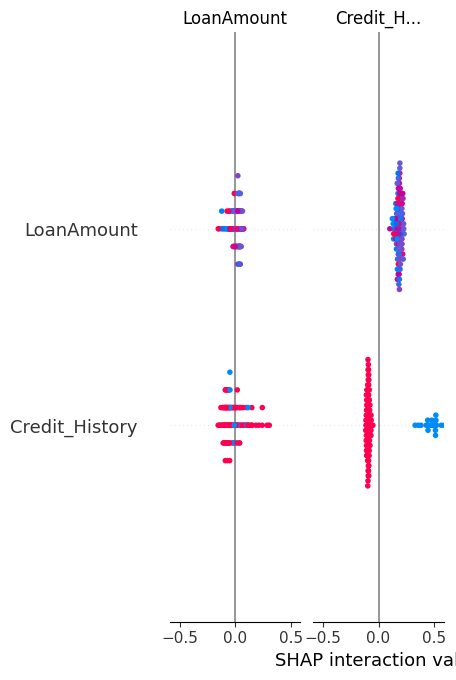

In [46]:
#Model Explainability

import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [47]:
# Prediction

# New data (example)
new_data = pd.DataFrame({
    'ApplicantIncome': [5000],
    'CoapplicantIncome': [2000],
    'LoanAmount': [150],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],
    'Gender': ['Male'],
    'Married': ['Yes'],
    'Dependents': ['0'],
    'Education': ['Graduate'],
    'Self_Employed': ['No'],
    'Property_Area': ['Urban']
})

# Apply preprocessing to new data
new_data_preprocessed = preprocessor.transform(new_data)

# Ensure new_data_preprocessed is a DataFrame
new_data_preprocessed_df = pd.DataFrame(new_data_preprocessed, columns=feature_names)

# Ensure the new data has the same feature set as used during training
new_data_preprocessed_df = new_data_preprocessed_df[top_n_features]

# Make prediction
new_prediction = best_model.predict(new_data_preprocessed_df)
new_prediction_proba = best_model.predict_proba(new_data_preprocessed_df)

print(f'Prediction: {"Approved" if new_prediction[0] == 1 else "Rejected"}')
print(f'Prediction Probability: {new_prediction_proba[0]}')

Prediction: Approved
Prediction Probability: [0.06888452 0.93111548]
